In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import glob
import matplotlib.pyplot as plt
import splitfolders

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
base_dir = './'


train_dir = os.path.join(base_dir, 'PetImages/')

cats_dir = os.path.join(train_dir,'Cat')
dogs_dir = os.path.join(train_dir, 'Dog')


In [4]:
print('Total cats images :', len(os.listdir(cats_dir)))
print('Total dogs images :', len(os.listdir(dogs_dir)))

Total cats images : 12501
Total dogs images : 12501


### train, valid, test 셋으로 나누기 

In [5]:
#splitfolders.ratio(train_dir, './Pet_split/', seed = 77, ratio=(.8, 0.1, 0.1))

In [6]:
pwd

'c:\\Users\\asy10\\ML\\DNN\\basic_torch'

In [7]:
train_dir = os.path.join(base_dir, 'Pet_split/train/')
valid_dir = os.path.join(base_dir, 'Pet_split/val')
test_dir = os.path.join(base_dir, 'Pet_split/test')

train_cat_dir = os.path.join(train_dir, 'Cat')
train_dog_dir = os.path.join(train_dir, 'Dog')

valid_cat_dir = os.path.join(valid_dir, 'Cat')
valid_dog_dir = os.path.join(valid_dir, 'Dog')

test_cat_dir = os.path.join(test_dir, 'Cat')
test_dog_dir = os.path.join(test_dir, 'Dog')


print('Total train cat images :', len(os.listdir(train_cat_dir)))
print('Total train dog images :', len(os.listdir(train_dog_dir)))

print('Total valid cat images :', len(os.listdir(valid_cat_dir)))
print('Total valid dog images :', len(os.listdir(valid_dog_dir)))

print('Total test images :', len(os.listdir(test_cat_dir)))
print('Total test images :', len(os.listdir(test_dog_dir)))

Total train cat images : 10000
Total train dog images : 9999
Total valid cat images : 1248
Total valid dog images : 1249
Total test images : 1251
Total test images : 1251


In [8]:
train_cat_dir

'./Pet_split/train/Cat'

### 이미지 전처리 

In [9]:
trans = transforms.Compose([
        transforms.RandomResizedCrop(256), # 랜덤하게  crop한 후 크키만큼 resize 
        transforms.RandomHorizontalFlip(), # 좌우반전
        transforms.ToTensor(), # numpy array를 tensor로 변경 
        transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                        ) # 0~1사이의 값으로 normalize
        ])

test_trans = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(), # numpy array를 tensor로 변경 
        
        ])


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from torchvision.transforms.functional import to_pil_image

def pil_to_tensor(pil_image):
    # PIL: [width, height]
    # -> NumPy: [width, height, channel]
    # -> Tensor: [channel, width, height]
    return torch.as_tensor(np.asarray(pil_image)).permute(2,0,1)

def tensor_to_pil(tensor_image):
    return to_pil_image(tensor_image)

def tensor_to_pltimg(tensor_image): # transfroms들이 [height, width, channel] 순서의 텐서로 처리 
    return tensor_image.permute(1,2,0).numpy()

In [11]:
ex_image = os.path.join(train_cat_dir, '0.jpg')

C:\Users\asy10\AppData\Local\Temp\ipykernel_36116\4044790904.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:189.)
  return torch.as_tensor(np.asarray(pil_image)).permute(2,0,1)


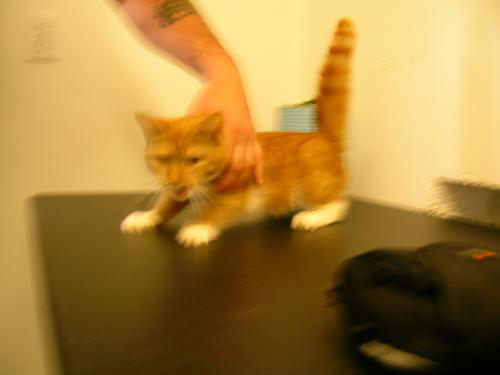

In [12]:
pil_image = PIL.Image.open(ex_image)
tensor_to_pil(pil_to_tensor(pil_image))

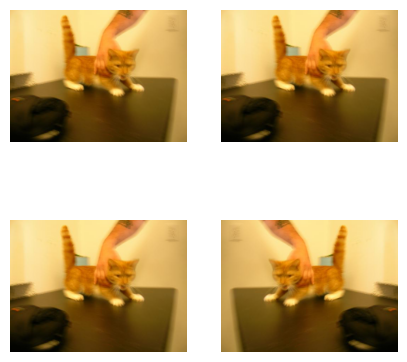

In [13]:
#https://blog.joonas.io/193
## 좌우 반전 
transform = transforms.RandomHorizontalFlip()


plt.figure(figsize=(5, 5))
for i in range(4):
    pil_image = PIL.Image.open(ex_image)
    tensor = pil_to_tensor(pil_image)
    applied_image = transform(tensor)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(tensor_to_pltimg(applied_image))
    plt.axis("off")
plt.show()

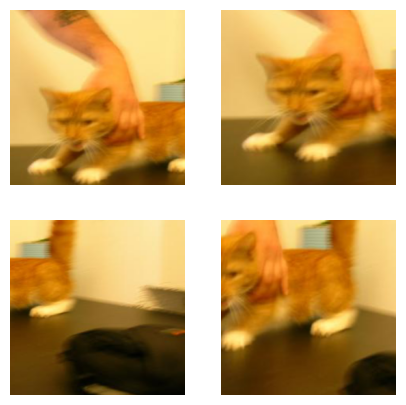

In [14]:
## 랜덤한 사이즈로 crop 후 사이즈 256으로 조절 
transform = transforms.RandomResizedCrop(256)


plt.figure(figsize=(5, 5))
for i in range(4):
    pil_image = PIL.Image.open(ex_image)
    tensor = pil_to_tensor(pil_image)
    applied_image = transform(tensor)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(tensor_to_pltimg(applied_image))
    plt.axis("off")
plt.show()

### 이미지 정규화
https://sparrow.dev/pytorch-normalize/

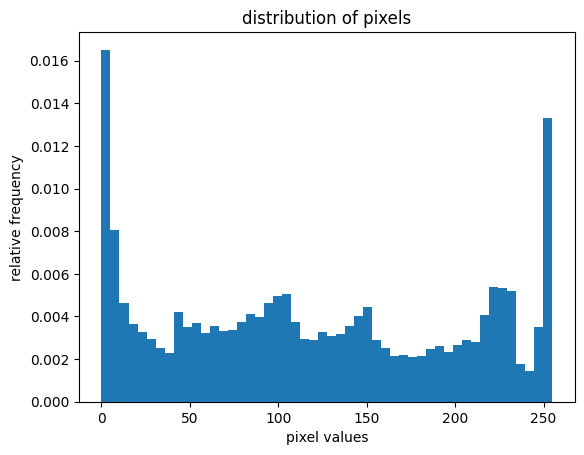

In [15]:
#before pixel normalize 
plt.hist(np.array(PIL.Image.open(ex_image)).ravel(), bins=50, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

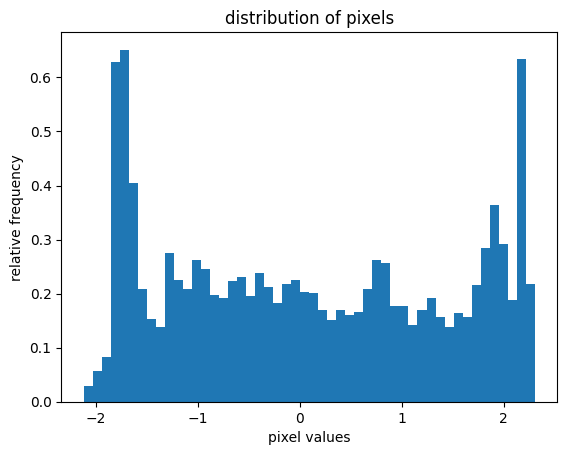

In [16]:
#after pixel normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])
normalized_img = transform(PIL.Image.open(ex_image))
plt.hist(np.array(normalized_img).ravel(), bins=50, density=True);
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


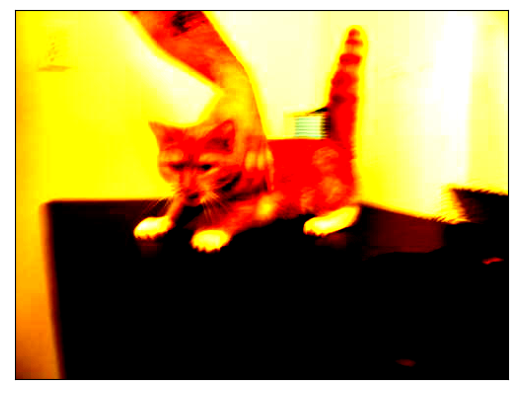

In [17]:
plt.imshow(np.array(normalized_img).transpose(1, 2, 0))
plt.xticks([])
plt.yticks([]);

### 데이터셋 만들기 

https://albumentations.ai/docs/examples/pytorch_classification/

https://ndb796.tistory.com/559


1. ImageFolder를 이용해서 데이터셋 만들기 

In [18]:
train_set = torchvision.datasets.ImageFolder(root = train_dir, transform=trans)
valid_set = torchvision.datasets.ImageFolder(root = valid_dir, transform=trans)
test_set = torchvision.datasets.ImageFolder(root=test_dir, transform=test_trans)

In [19]:
# PIL.image.open()은 grayscale로 이미지를 읽는다. 아래 코드는 PIL에서 컬러로 이미지를 읽는 코드 
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            
            return img.convert('RGB')

2. Custom Dataset을 선언해서 데이터셋 만들기 

In [20]:
class catdogDataset(Dataset):
    def __init__(self,path,transform=None): # 데이터셋 전처리 
        
        self.path = path
        self.cat_directory = os.path.join(self.path, "Cat")
        self.dog_directory = os.path.join(self.path, "Dog")

        self.cat_images_filepaths = sorted([os.path.join(self.cat_directory, f) for f in os.listdir(self.cat_directory)])
        self.dog_images_filepaths = sorted([os.path.join(self.dog_directory, f) for f in os.listdir(self.dog_directory)])
        self.images_filepaths = [*self.cat_images_filepaths, *self.dog_images_filepaths]
        
        self.transform = transform
        
        
    
    def __len__(self):
        
        self.file_len = len(self.images_filepaths)
        return self.file_len
   
        
        
    def __getitem__(self, index):
        
        img_path = self.images_filepaths[index]
        image = pil_loader(img_path)
        if os.path.normpath(img_path).split(os.sep)[-2] == "Cat":
            label = 1
        else:
            label = 0
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [21]:
train_dataset = catdogDataset(path = train_dir,transform=trans)
valid_dataset = catdogDataset(path = valid_dir,transform=trans)
test_dataset = catdogDataset(path = test_dir, transform=test_trans)

### DataLoader 만들기
- 데이터셋을 배치사이즈씩 묶는다

In [22]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=16, shuffle=True )
valid_loader = torch.utils.data.DataLoader(dataset = valid_dataset, batch_size=16, shuffle=True )
test_loader =  torch.utils.data.DataLoader(dataset = test_dataset, batch_size=8, shuffle=True )

In [23]:
imgs, labels = next(iter(train_loader))
imgs.shape # [batch, channel, with, height]

torch.Size([16, 3, 256, 256])

In [24]:
imgs, labels = next(iter(valid_loader))
imgs.shape # [batch, channel, with, height]

torch.Size([16, 3, 256, 256])

In [25]:
labels_map = {0 : 'dog', 1: 'cat'}

In [26]:
labels[1].item() # 1-d tensor to int

1

In [27]:
imgs[1].shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

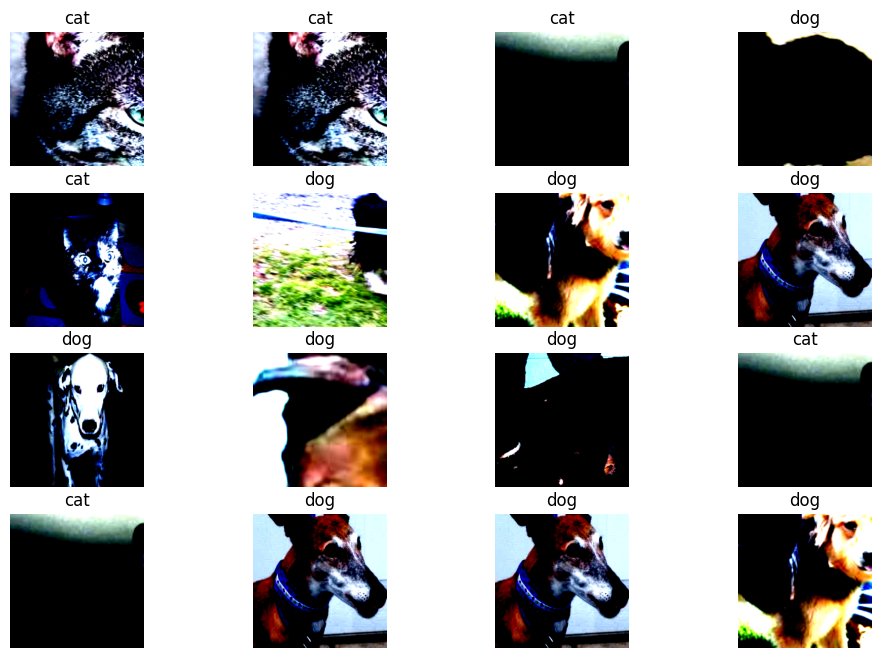

In [28]:
fig = plt.figure(figsize=(12,8))
col, row = 4, 4

    # PIL: [width, height]
    # -> NumPy: [width, height, channel]
    # -> Tensor: [channel, width, height]
for i in range(1, col * row + 1):
    sample_idx = torch.randint(len(imgs), size=(1,)).item()
    img, label = imgs[sample_idx], labels[sample_idx].item()
    fig.add_subplot(row, col, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(tensor_to_pltimg(img))#plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [29]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        
        
        self.drop_out = nn.Dropout()
        
        self.fc1 = nn.Linear(128*3*3, 512)
        self.fc2 = nn.Linear(512,2)
        
    def forward(self, x):
        #print(f"input : {x.size()}") 
        out = F.relu(self.layer1(x))
        #print(f"layer 1 통과 : {out.size()}")
        out = F.relu(self.layer2(out))
        #print(f"layer 2 통과 : {out.size()}")
        out = F.relu(self.layer3(out))
        #print(f"layer 3 통과 : {out.size()}")
        
        
        out = out.view(out.size(0), -1) # 차원 축소 
        
        #print(f"차원축소 : {out.size()}")
        out = self.drop_out(out)
        #print(f"drop out : {out.size()}")
        out = F.relu(self.fc1(out))
        #print(f"fc1 통과 : {out.size()}")
        out = self.fc2(out)
        #print(f"fc2 통과 : {out.size()}")
        return out

mo = Model()
output = mo(torch.randn(100, 3, 256, 256))
        

In [31]:
model = Model()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [32]:
torch.cuda.empty_cache()

In [33]:
epochs = 10

for epoch in range(epochs):
    epoch_loss =0
    epoch_accuracy = 0
    
    for imgs,labels in train_loader:
        imgs,labels  = imgs.to(device), labels.to(device)
        
        
        outputs = model(imgs)
        loss = criterion(outputs,labels) # loss 계산 
        
        optimizer.zero_grad() # backprpoagation 실행 전에 gradient 0으로 초기화
        loss.backward()# gradient 계산 
        optimizer.step()# 모델 parameter update 
        
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax).float().mean()
        
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))
    
    #batch norm, dropout은 train, valid 에서 작동하는 방식이 다르다. 
    model.eval() 
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0
        for imgs,labels in  valid_loader:
            imgs,labels  = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs,labels)


            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, correct / total * 100, avrg_loss))
    model.train() # validation이 끝나고 다시 train모드로 변경 

c:\Users\asy10\Anaconda3\envs\pt_nlp\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [1/10], Step [17/1250], Loss: 0.8329, Accuracy: 60.00%
Validation #0  Accuracy: 58.51%  Average Loss: 0.6741
Epoch [2/10], Step [17/1250], Loss: 0.6991, Accuracy: 46.67%
Validation #1  Accuracy: 65.84%  Average Loss: 0.6219
Epoch [3/10], Step [17/1250], Loss: 0.4411, Accuracy: 80.00%
Validation #2  Accuracy: 67.60%  Average Loss: 0.5996
Epoch [4/10], Step [17/1250], Loss: 0.4425, Accuracy: 86.67%
Validation #3  Accuracy: 65.04%  Average Loss: 0.6147
Epoch [5/10], Step [17/1250], Loss: 0.5244, Accuracy: 60.00%
Validation #4  Accuracy: 70.12%  Average Loss: 0.5840
Epoch [6/10], Step [17/1250], Loss: 0.7568, Accuracy: 60.00%
Validation #5  Accuracy: 71.77%  Average Loss: 0.5560
Epoch [7/10], Step [17/1250], Loss: 0.4552, Accuracy: 80.00%
Validation #6  Accuracy: 72.33%  Average Loss: 0.5341
Epoch [8/10], Step [17/1250], Loss: 0.3479, Accuracy: 86.67%
Validation #7  Accuracy: 70.48%  Average Loss: 0.5611
Epoch [9/10], Step [17/1250], Loss: 1.0206, Accuracy: 33.33%
Validation #8  Accu

### Test

In [36]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        
        outputs = model(imgs)
        
        _, argmax = torch.max(outputs, 1)    # max()를 통해 최종 출력이 가장 높은 class 선택
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()

    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
model.train()

Test accuracy for 2502 images: 50.84%


Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=Tru

In [37]:
from tqdm import tqdm

sample_pred_images = None
with torch.no_grad():
    pred_ids = torch.empty(0)
    pred_labels = torch.empty(0)
    for images, labels in tqdm(test_loader):
        
        outputs = model(images.to(device))
        _, pred = torch.max(outputs.data, 1)
        # append list
        pred_ids = torch.cat([pred_ids, images])
        pred_labels = torch.cat([pred_labels, pred.to('cpu')])
        # save image to show
        if sample_pred_images is None:
            sample_pred_images = (images, pred)

100%|██████████| 313/313 [01:00<00:00,  5.17it/s]


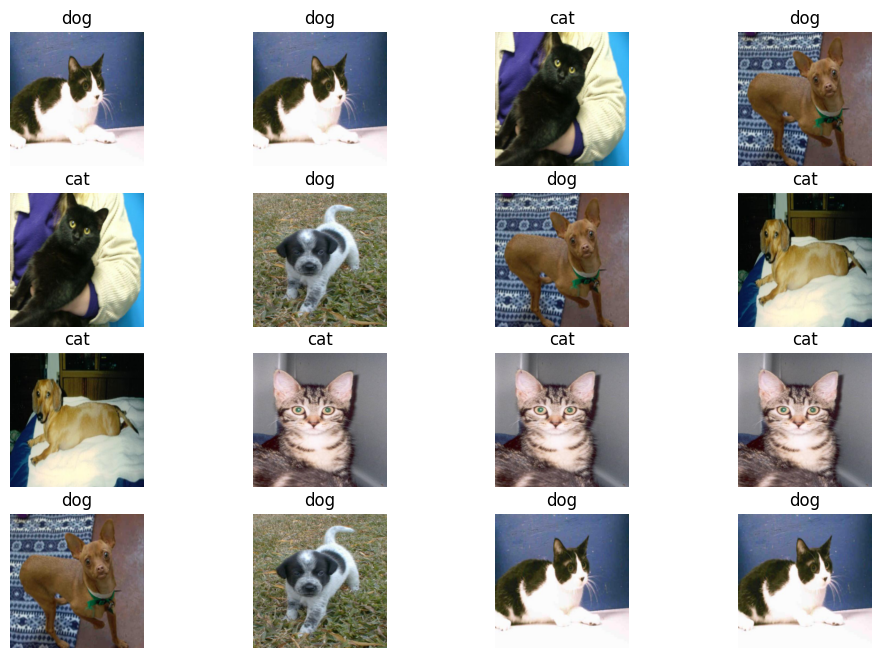

In [38]:
fig = plt.figure(figsize=(12,8))
col, row = 4, 4

    # PIL: [width, height]
    # -> NumPy: [width, height, channel]
    # -> Tensor: [channel, width, height]
for i in range(1, col * row + 1):
    sample_idx = torch.randint(len(imgs), size=(1,)).item()
    img, label = pred_ids[sample_idx], pred_labels[sample_idx].item()
    fig.add_subplot(row, col, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(tensor_to_pltimg(img))#plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

### Transfer learning

In [43]:
new_model = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\asy10/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [44]:
new_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [48]:
new_model.fc = torch.nn.Linear(2048,1000)
new_model.fc2 = torch.nn.Linear(1000,2)
new_model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
for param in new_model.parameters():
    param.requires_grad = False
for param in new_model.fc.parameters(): # classifier만 새로 학습 시키기 
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()  
new_model = new_model.to(device)
optimizer = optim.Adam(new_model.parameters(), lr=LEARNING_RATE) 


### Transfer learnging 
Train

In [56]:
epochs = 10

for epoch in range(epochs):
    epoch_loss =0
    epoch_accuracy = 0
    
    for imgs,labels in train_loader:
        imgs,labels  = imgs.to(device), labels.to(device)
        
        
        outputs = new_model(imgs)
        loss = criterion(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax).float().mean()
        
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))
    
    new_model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0
        for imgs,labels in  valid_loader:
            imgs,labels  = imgs.to(device), labels.to(device)

            outputs = new_model(imgs)
            loss = criterion(outputs,labels)


            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, correct / total * 100, avrg_loss))
    new_model.train()

Epoch [1/10], Step [17/1250], Loss: 0.0000, Accuracy: 100.00%
Validation #0  Accuracy: 89.23%  Average Loss: 6.1417
Epoch [2/10], Step [17/1250], Loss: 0.0000, Accuracy: 100.00%
Validation #1  Accuracy: 94.99%  Average Loss: 2.3228
Epoch [3/10], Step [17/1250], Loss: 0.0000, Accuracy: 100.00%
Validation #2  Accuracy: 96.20%  Average Loss: 2.7756
Epoch [4/10], Step [17/1250], Loss: 2.6053, Accuracy: 86.67%
Validation #3  Accuracy: 95.19%  Average Loss: 2.8124
Epoch [5/10], Step [17/1250], Loss: 4.0742, Accuracy: 86.67%
Validation #4  Accuracy: 93.07%  Average Loss: 5.1007
Epoch [6/10], Step [17/1250], Loss: 0.0000, Accuracy: 100.00%
Validation #5  Accuracy: 95.84%  Average Loss: 2.0987
Epoch [7/10], Step [17/1250], Loss: 4.7039, Accuracy: 93.33%
Validation #6  Accuracy: 93.23%  Average Loss: 4.7298
Epoch [8/10], Step [17/1250], Loss: 16.1750, Accuracy: 80.00%
Validation #7  Accuracy: 94.75%  Average Loss: 3.3505
Epoch [9/10], Step [17/1250], Loss: 0.0000, Accuracy: 100.00%
Validation #8

#### Test

In [59]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        
        outputs = new_model(imgs)
        
        _, argmax = torch.max(outputs, 1)    # max()를 통해 최종 출력이 가장 높은 class 선택
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()

    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
model.train()

Test accuracy for 2502 images: 89.01%


Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=Tru

In [60]:
from tqdm import tqdm

sample_pred_images = None
with torch.no_grad():
    pred_ids = torch.empty(0)
    pred_labels = torch.empty(0)
    for images, labels in tqdm(test_loader):
        
        outputs = new_model(images.to(device))
        _, pred = torch.max(outputs.data, 1)
        # append list
        pred_ids = torch.cat([pred_ids, images])
        pred_labels = torch.cat([pred_labels, pred.to('cpu')])
        # save image to show
        if sample_pred_images is None:
            sample_pred_images = (images, pred)

100%|██████████| 313/313 [01:03<00:00,  4.95it/s]


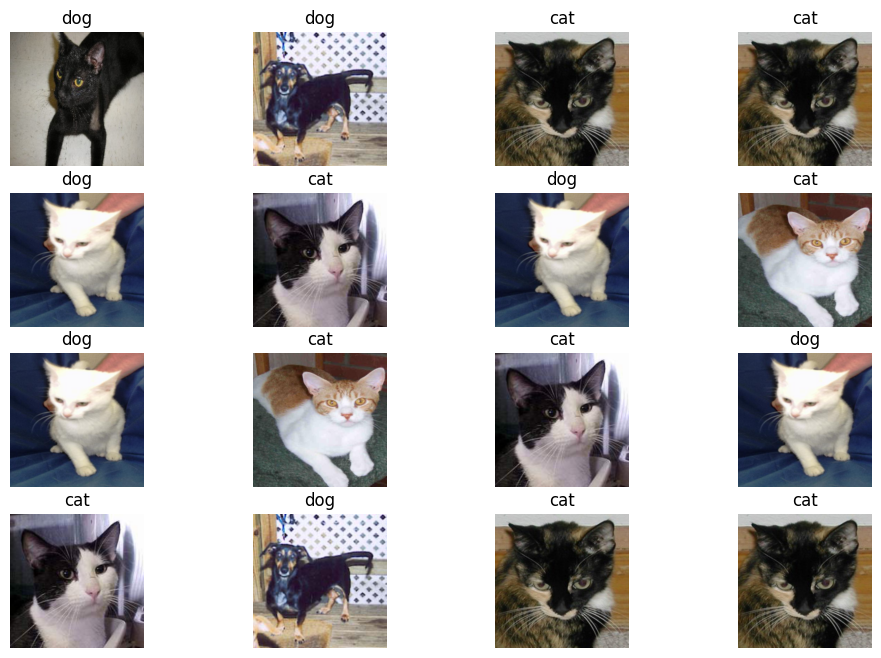

In [61]:
fig = plt.figure(figsize=(12,8))
col, row = 4, 4

    # PIL: [width, height]
    # -> NumPy: [width, height, channel]
    # -> Tensor: [channel, width, height]
for i in range(1, col * row + 1):
    sample_idx = torch.randint(len(imgs), size=(1,)).item()
    img, label = pred_ids[sample_idx], pred_labels[sample_idx].item()
    fig.add_subplot(row, col, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(tensor_to_pltimg(img))#plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()